In [4]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os

from pyspecter.SPECTER import SPECTER
from pyspecter.Observables import Observable
# from pyspecter.SpecialObservables import SpecialObservables

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
from pyspecter.utils.plot_utils import newplot, plot_event

# Jax
from jax import grad, jacobian, jit
import jax.numpy as jnp
from jax import random

# SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

# Dataset

In [5]:
# Parameters 
R = 1
N = 180

# print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

this_dir = ""
this_study = "triangles"


dataset_open, sim_weights, k = load_cmsopendata("~/.energyflow/", "sim", 475, 525, 1.9, 2, pad = 75, n = 1000)
triangle_events, triangle_indices = load_triangles(180, 180, R = 1.0, return_indices=True)

dataset = triangle_events

Current working directory: /home/rikab/Documents/Research/SPECTER/Studies/n_subjettiness
Max # of particles: 124


# Construct Train Step for N-Subjettiness

[[0.         0.509441  ]
 [1.         0.21903187]
 [1.         0.21903187]
 [1.7378714  0.05249524]]
[[0.        0.6880889]
 [1.        0.3119111]]


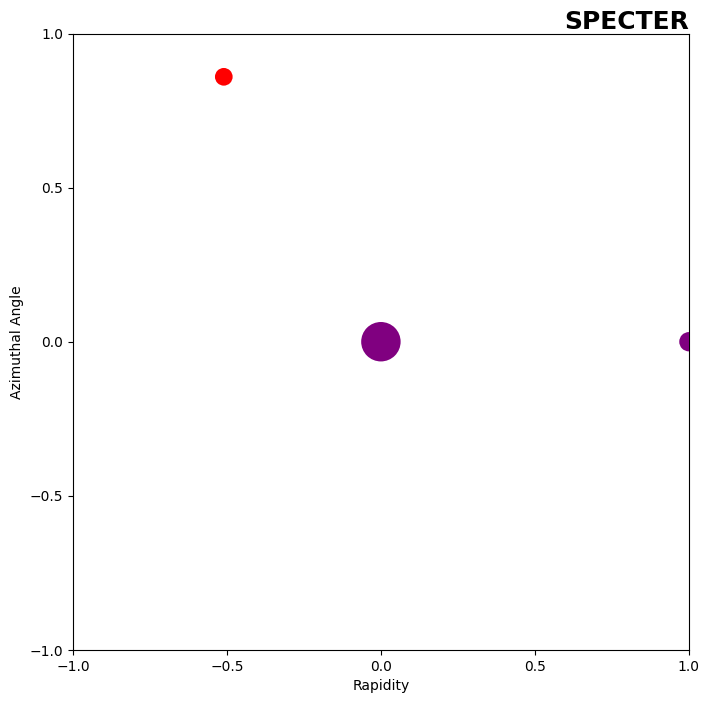

In [ ]:
# Initializer
# import fastjet._pyjet  # noqa: F401

# from fastjet._pyjet import ClusterSequence, JetDefinition, PseudoJet

# import pyfjcore

from pyjet import cluster

def kT_N(events, N, R):

    jets = []

    for event in events:

        # Set up 4-vectors
        four_vectors = []
        for particle in event:
            four_vectors.append((particle[0], particle[1], particle[2], 0))
        four_vectors = np.array(four_vectors, dtype=[("pt", "f8"), ("eta", "f8"), ("phi", "f8"), ("mass", "f8")])

        # Cluster with kT (p = 1)
        sequence = cluster(four_vectors, R=R, p=1)
        subjets = sequence.exclusive_jets(N)

        output = np.zeros((N, 3))
        for i, subjet in enumerate(subjets):
            output[i,0] = subjet.pt
            output[i,1] = subjet.eta
            output[i,2] = subjet.phi


        # Normalize
        output[:,0] = np.nan_to_num(output[:,0] / np.sum(output[:,0]))

        jets.append(output)


    return np.array(jets)


event0 = dataset[180*120 + 121]
kt2 = kT_N(dataset, 2, R)[180*120 + 121]

print(compute_spectral_representation(event0)   )
print(compute_spectral_representation(kt2)   )

# print(ds2_events1_spectral2(event0, compute_spectral_representation(kt2)))

fig, ax =  newplot()
ax = plot_event(event0, R, ax, color = "red", show = False)
ax = plot_event(kt2, R, ax, color = "purple", show = False)

In [ ]:
from pyspecter.SpectralEMD_Helper import ds2_events1_spectral2
import jax.example_libraries.optimizers as jax_opt
from jax.example_libraries import optimizers
import jax
import tqdm


# Gradients
vmap_compute_spectral_representation = jax.vmap(compute_spectral_representation, in_axes = 0)
vmap_ds2_events1_spectral2 = jax.vmap(ds2_events1_spectral2)
ds2_events1_spectral2_gradients = grad(ds2_events1_spectral2, )
vmap_ds2_events1_spectral2_gradients = jax.vmap(ds2_events1_spectral2_gradients)


# Function to enforce normalization of energies
def project(events):

    temp = jnp.copy(events)
    zs = events[:,:,0]
    num_particles = events.shape[1]
    batch_size = events.shape[0]

    cnt_n = jnp.arange(num_particles)
    cnt_i = jnp.arange(batch_size)

    u = jnp.sort(zs, axis = -1)[:,::-1]
    v = (jnp.cumsum(u, axis = -1)-1) / (cnt_n + 1)
    w = v[cnt_i, jnp.sum(u > v, axis = -1) - 1]
    temp2 = temp.at[:,:,0].set(jnp.maximum(zs - w[:,None], 0))

    # temp = temp.at[:,:,0].set(jnp.maximum(temp[:,:,0], 0))
    # return temp

    return temp2

# For N-spronginess, the shape is just the params
def shape_from_params(params):
    return params


def initialize(events, N, seed):

    # new_events = jnp.ones((events.shape[0], N, 3)) / N
    # new_events = new_events.at[:,:,1:3].set(R/4 * jax.random.normal(seed, (N, 2)))
    # # new_events = new_events.at[:,0,1:3].set( (0,.000))
    # # new_events = new_events.at[:,1,1:3].set( (1,0))


    return kT_N(events, N, R)

def compute_N_spronginess(events, N, epochs = 100, learning_rate = 1e-2):
    
    # Get spectral representation of events:
    events_spectral = vmap_compute_spectral_representation(events)

    # Initialize events
    shape_events = initialize(events, N, seed = random.PRNGKey(0))

    
    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(learning_rate)
    opt_state = opt_init(shape_events)

    losses = np.zeros((epochs, events.shape[0]))


    for epoch in tqdm.tqdm(range(epochs)):


        params = get_params(opt_state)
        shape_events = shape_from_params(params)
        shape_events = project(shape_events)
        sEMDs, grads = train_step(epoch, events_spectral, shape_events)
        opt_state = opt_update(epoch, grads, opt_state)

       # Apply the separate function to modify the parameters
        new_params = project(get_params(opt_state))

        # Manually modify the opt_state's parameters without resetting internal state
        opt_state = replace_params_in_state(opt_state, new_params)
        losses[epoch] = sEMDs
        


    return jnp.min(losses, axis = 0), shape_events, losses

def replace_params_in_state(opt_state, new_params):
    if isinstance(opt_state, tuple) and len(opt_state) == 2 and isinstance(opt_state[0], dict):
        # This is the parameter tuple for Adam
        return (new_params, opt_state[1])
    elif isinstance(opt_state, tuple):
        # Unpack and modify recursively
        return tuple(replace_params_in_state(sub_state, new_params) for sub_state in opt_state)
    else:
        # Leaf node or unknown type, return unchanged
        return opt_state

@jax.jit
def train_step(epoch, spectral_events, shape_events):

    sEMDS = vmap_ds2_events1_spectral2(shape_events, spectral_events)
    grads = vmap_ds2_events1_spectral2_gradients(shape_events, spectral_events)
    return sEMDS, jnp.nan_to_num(grads)




100%|██████████| 1000/1000 [00:30<00:00, 32.61it/s]


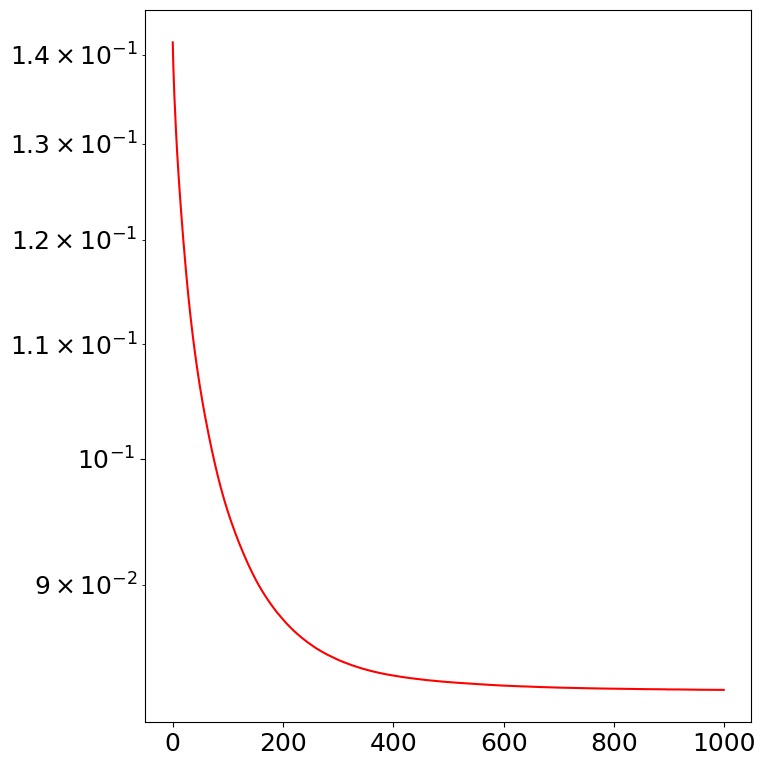

In [ ]:
sEMDs, shape_events, losses = compute_N_spronginess(triangle_events, 2, epochs = 1000, learning_rate = 1e-2)

filename = f"{this_study}_sEMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, sEMDs)

# plot the average loss per epoch
plt.plot(np.mean(losses, axis = -1))
plt.yscale("log")

# Closed Form Expressions

In [ ]:
def theta(x):
    return x > 0


def find_omega12(spectral_events, two_E1E2):

    omega = spectral_events[:,0]
    two_EE = spectral_events[:,1]



    cumulative = jnp.cumsum(spectral_events[:,1], axis = -1)
    cumulative_exclusive = cumulative - spectral_events[:,1]
    total_energy = cumulative[-1]

    term1 = (two_EE) / two_E1E2
    theta1 = theta(two_E1E2 - total_energy + cumulative_exclusive)

    term2 = 1 - (total_energy - cumulative) / two_E1E2
    theta2a = 1 - theta1
    theta2b = theta(two_E1E2 - total_energy + cumulative)
    theta2 = theta2a * theta2b

    total = jnp.sum(omega * (term1 * theta1 + term2 * theta2), axis = -1)
    return total

vmap_find_omega12 = jax.vmap(jax.jit(find_omega12), in_axes = (0, None))

def closed_form_2_spronginess(events, levels = 50):

    two_E1E2 = np.linspace(0.0001, 1/2, levels)
    sEMDs = np.zeros((levels, events.shape[0]))

    spectral_events = vmap_compute_spectral_representation(events)


    for i in tqdm.tqdm(range(levels)):
        find_omega12 = vmap_find_omega12(spectral_events, two_E1E2[i])
        term_1 = np.sum(spectral_events[:,:,0]**2 * spectral_events[:,:,1] , axis = -1)
        term_2 = two_E1E2[i] * find_omega12**2

        sEMDs[i] = term_1 - term_2

    # Take the minimum over all levels
    return np.min(sEMDs, axis = 0)





In [ ]:
closed_form_sEMDs = closed_form_2_spronginess(triangle_events, levels = 150)
print(closed_form_sEMDs)

filename = f"{this_study}_closed_form_sEMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, closed_form_sEMDs)

100%|██████████| 150/150 [00:00<00:00, 231.17it/s]

[0.         0.00094568 0.0013946  ... 0.0014097  0.00097689 0.        ]


# SHAPER

In [ ]:
# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 


# Generate new events

R = 1.0
N = 180
angles = np.linspace(0, np.pi, N)
energies = np.linspace(0, 1, N)

events = []
for i in range(N):
    temp = []
    for j in range(N):

        e = energies[j]
        zs = np.array([e, (1-e)/2, (1-e)/2])
        points = np.array([
                            (0.0, 0.0),
                            (R, 0.0),
                            (R*np.cos(angles[i]), R*np.sin(angles[i]))
                ])
        temp.append((points, zs))
    events.append(temp)


# EMDs

commonObservables, pointers = buildCommmonObservables(N = 3, beta = 2, R = R, device = device)
_2subjettiness = commonObservables["2-Subjettiness"]


# Collect our observables in one dictionary
observables = {}
observables["2-Subjettiness"] = _2subjettiness

# Initialize SHAPER
shaper = Shaper(observables, device)
shaper.to(device)


EMDs = []
for (i,batch) in enumerate(events):

    temp = []
    print("BATCH: %d" % i)


    dataset_emds, dataset_params = shaper.calculate(batch, epochs = 500, verbose=True, lr = 0.01, N = 50, scaling = 0.9, epsilon = 0.001, early_stopping= 25)
    for j in range(N):
        e = dataset_params["2-Subjettiness"][j]["EMD"]
        temp.append(e)

    EMDs.append(temp)

EMDs = np.array(EMDs)

filename = f"{this_study}_shaper_EMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, EMDs)

Using CPU!
BATCH: 0
Observable: 2-Subjettiness Epoch 0 Mean Loss = -2.3996052058963516e-12 Elapsed time = 0.035s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 1 Mean Loss = 7.75869963951613e-05 Elapsed time = 0.076s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 2 Mean Loss = 0.0005023421410644207 Elapsed time = 0.108s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 3 Mean Loss = 5.0282949652884986e-05 Elapsed time = 0.140s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 4 Mean Loss = 0.00024293139803275053 Elapsed time = 0.172s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 5 Mean Loss = 0.0003397918202810817 Elapsed time = 0.206s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 6 Mean Loss = 0.0001402309499907359 Elapsed time = 0.241s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 7 Mean Loss = 1.5900078415143072e-05 Elapsed time = 0.274s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 8 Mean Loss = 9

KeyboardInterrupt: 

# Plots

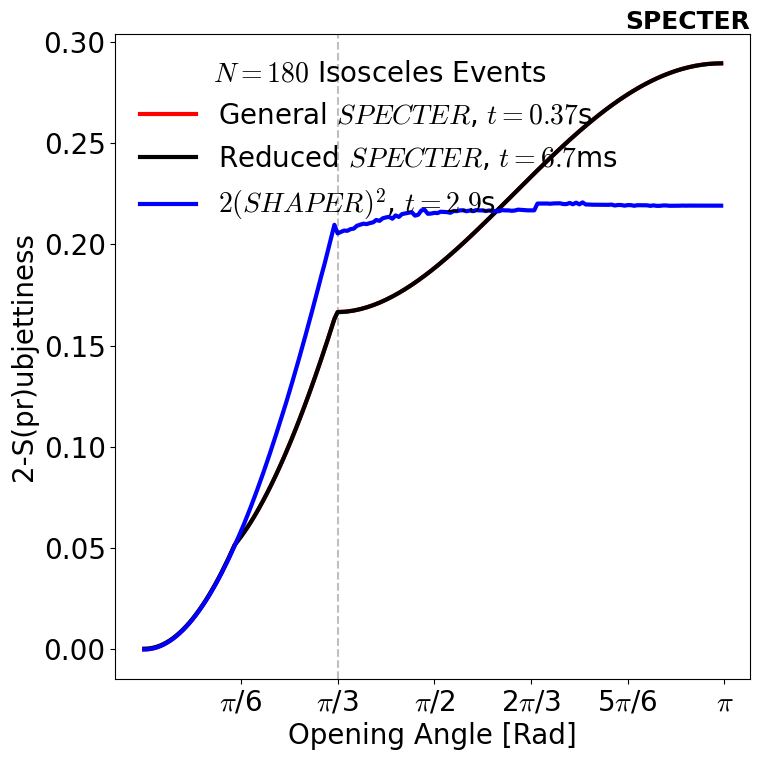

In [12]:
triangle_events_matrix = np.zeros((180, 180, 3))


# Load numpy data
sEMDs = np.load(os.path.join(this_dir, f"{this_study}_sEMDs.npy"))
closed_form_sEMDs = np.load(os.path.join(this_dir, f"{this_study}_closed_form_sEMDs.npy"))
EMDs = np.load(os.path.join(this_dir, f"{this_study}_shaper_EMDs.npy"))


sEMDs_matrix = np.zeros((180, 180))
sEMDs_matrix[triangle_indices[:,0], triangle_indices[:,1]] = sEMDs
# sEMDs_matrix = sEMDs.reshape(N,N)

closed_form_sEMDs_matrix = np.zeros((180, 180))
closed_form_sEMDs_matrix[triangle_indices[:,0], triangle_indices[:,1]] = closed_form_sEMDs
# closed_form_sEMDs_matrix = closed_form_sEMDs.reshape(N,N)

newplot()
index = 61
plt.plot(sEMDs_matrix[:,index], label = r"General $SPECTER$, $t = 0.37$s", lw = 3, color = "red")
plt.plot(closed_form_sEMDs_matrix[:,index], label =  r"Reduced $SPECTER$, $t = 6.7$ms", lw = 3, color = "darkred")
plt.plot(2 * np.square(np.array(EMDs.reshape(N,N)[:,index])), color = "blue", label = r"$2(SHAPER)^2$, $t = 2.9$s", lw = 3, color = "purple")
plt.axvline(60, color = "black", linestyle = "--", alpha = 0.25)


# Axis labels of pi/6, pi/3, pi/2, 2pi/3, 5pi/6
plt.xticks([30, 60, 90, 120, 150, 180], [r"$\pi$/6", r"$\pi$/3", r"$\pi$/2", r"2$\pi$/3", r"5$\pi$/6", r"$\pi$"])

plt.ylim(0, 0.40)

plt.xlabel("Opening Angle [Rad]")
plt.ylabel(r"2-S(pr)ubjettiness")
plt.legend(frameon = False, loc = "upper left", title = r"$N = 180$ Isosceles Events")